# Quantum Trajectories

In [1]:
#Import basic modules
import numpy as np
from scipy import linalg
import matplotlib.pyplot as plt
%matplotlib inline
import time

In [2]:
#This block is needed to create homogeneous plots throughout the project
fparams = {'axes.labelsize': 22,
           'axes.titlesize': 25,
           'axes.linewidth': 1.5,
           'font.size': 16,
           'legend.fontsize': 15,
           'font.family': 'serif',
           'font.serif': 'Computer Modern Roman',
           'xtick.labelsize': 15,
           'xtick.major.size': 5.5,
           'xtick.major.width': 1.5,
           'ytick.labelsize': 15,
           'ytick.major.size': 5.5,
           'ytick.major.width': 1.5,
           'text.usetex': True,
           'figure.autolayout': True}
plt.rcParams.update(fparams)

## Two level Jump operators

Below is a function which calculates the time evolution for different types of jump-operators. It returns the density matrix, dipole moment and energy at each time step. 

In [3]:
def two_level_jump(Jump_operator, omega = 1, gamma = 0.1, beta = 1, Nt = 1000, T2 = 10, dt = 0.01, N_ensembles = 1000, 
                  save = 'false'):
    """Calculate the time-evolution of the two level system for different types of jump-operators. Return the density matrix, 
    expectation value of dipole moment and expectation value of energy at each time step
    
    ------------
    - Jump_operator: str
    
    Type should be one of:
    'Transition'
    'Phase Noise'
    'Collision'
    'Boltzmann'
    """
    
    t = np.linspace(0,Nt*dt,Nt)
    Ns = N_ensembles
    # Initalize wavefunction
    psi = np.zeros((Nt,Ns,2),dtype = complex)
    psi[0,:,:] = 2 ** (-.5) * np.ones((Ns,2))
    rho = np.zeros((Nt,2,2),dtype = complex)
    H0 = np.array([[0,0], [0, omega]], dtype= 'complex')
    
    # Define Hamiltonian and time evolution operator
    if Jump_operator == 'Transition':
        Heff = (omega - 1j * gamma * .5 ) * np.array([[0 , 0],[0 , 1]], dtype = complex)
        Ueff = linalg.expm(- 1j * dt *Heff)
    
    elif (Jump_operator == 'Phase Noise'):
        Heff = (omega) * np.array([[0 , 0],[0 , 1]], dtype = complex)
        Ueff = linalg.expm(- 1j * dt *Heff)
    
    elif Jump_operator == 'Collision':
        Heff = (omega) * np.array([[0 , 0],[0 , 1]], dtype = complex)
        Ueff = linalg.expm(- 1j * dt *Heff)
        gamma = 1/T2
        
    elif Jump_operator == 'Boltzmann':
        b0 = 1/(1 + np.exp(-beta*omega))
        b1 = 1 - b0
        Heff = np.array([[-1j * gamma *.5 * b1 , 0],
                         [0 , (omega - 1j * gamma * .5 * b0 )]], dtype = complex)
        Ueff = linalg.expm(- 1j * dt *Heff)

    #Define X operator
    X = np.array([[0,1], [1,0]], dtype = complex)
    Z = np.array([[1,0], [0, -1]], dtype = complex)
    
    for i in range(Nt-1):
        dp = gamma * dt * np.absolute(psi[i,:,1]) ** 2
        e = np.random.uniform(0,1,(Ns))

        trans = np.where(e < dp)
        no_trans = np.where(e >= dp)
        
        if Jump_operator == 'Transition':
            # Transition to ground state
            psi[i+1,trans,:] = np.array([1, 0], dtype = complex)

            # Non unitary evolution
            psi[i+1,no_trans,:] = np.einsum('ij,...j', Ueff, psi[i,no_trans,:])
            
        elif Jump_operator == 'Phase Noise':
            #Unitary evolution
            psi[i+1,:,:] = np.einsum('ij,...j', Ueff, psi[i,:,:])
            
            #Random phase noise
            theta = np.sqrt(gamma * dt) * np.random.randn((Ns))
            psi[i+1,:,1] = np.exp(1j * theta) * psi[i+1,:,1]
        
        elif Jump_operator == 'Collision':
            # Transition to ground state
            psi[i+1,trans,:] = np.einsum('ij, ...j', Z, psi[i, trans,:])

            # Non unitary evolution
            psi[i+1,no_trans,:] = np.einsum('ij,...j', Ueff, psi[i,no_trans,:])

        else:
            dp0 = gamma * b0 * dt * np.absolute(psi[i,:,1]) ** 2 
            dp1 = gamma * b1 * dt * np.absolute(psi[i,:,0]) ** 2
            dp = dp0 + dp1
            e = np.random.uniform(0,1,(Ns))

            # Randomly choose which transition is made (if e < dp)
            e2 = np.random.uniform(0,1,(Ns))

            trans0 = np.where(np.logical_and(e < dp, dp0/dp > e2))
            trans1 = np.where(np.logical_and(e < dp, dp0/dp <= e2))
            no_trans = np.where(e >= dp)

            psi[i+1,trans0,:] = [1, 0]
            psi[i+1,trans1,:] = [0, 1]

            # Non unitary evolution
            psi[i+1,no_trans,:] = np.einsum('ij,...j', Ueff, psi[i,no_trans,:])

        
        # Normalize the wave function after non-unitary evolution
        psi[i+1,no_trans,0] /= linalg.norm(psi[i+1,no_trans,:], axis = 2)
        psi[i+1,no_trans,1] /= linalg.norm(psi[i+1,no_trans,:], axis = 2)

    
    dipole = np.einsum('...i,ij,...j', np.conj(psi), X, psi)
    energy = np.einsum('...i,ij,...j', np.conj(psi), H0, psi)/omega
    rho[:,0,0] = np.mean(np.conj(psi[:,:,0])*psi[:,:,0],axis = 1)
    rho[:,0,1] = np.mean(np.conj(psi[:,:,0])*psi[:,:,1],axis = 1)
    rho[:,1,0] = np.mean(np.conj(psi[:,:,1])*psi[:,:,0],axis = 1)
    rho[:,1,1] = np.mean(np.conj(psi[:,:,1])*psi[:,:,1],axis = 1)
    

    return rho, dipole, energy

### Run simulations

C:\Users\TU Delf SID\Anaconda3\lib\site-packages\numpy\core\numeric.py:474: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)
C:\Users\TU Delf SID\Anaconda3\lib\site-packages\matplotlib\figure.py:1744: UserWarning: This figure includes Axes that are not compatible with tight_layout, so its results might be incorrect.
  warnings.warn("This figure includes Axes that are not "


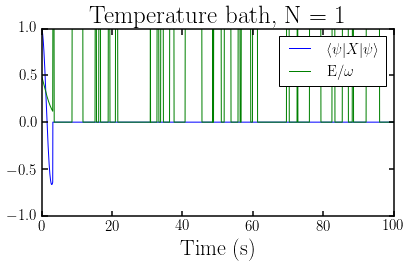

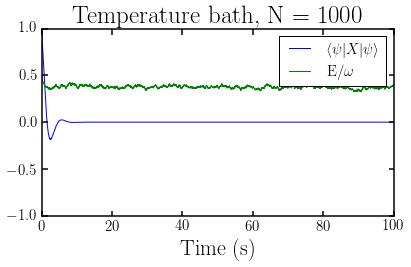

In [48]:
#Set parameters
Nt = 10000
dt = 0.01
gamma = 1
T2 = 10
beta = 0.5

rho1, dipole1, energy1 = two_level_jump(Jump_operator= 'Boltzmann', Nt = Nt, dt = dt, T2 = T2, beta = beta,
                                        gamma=gamma, N_ensembles=1)
rho1000, dipole1000, energy1000 = two_level_jump(Jump_operator='Boltzmann', Nt = Nt, dt = dt, T2 = T2, beta = beta,
                                                 gamma=gamma, N_ensembles=1000)
t = np.linspace(0,Nt*dt,Nt)

# plt.figure()
# plt.plot(abs(rho[:,0,0]), 'r')
# plt.plot(abs(rho[:,1,1]), 'b')
# plt.plot(np.real(rho[:,0,1]), 'm--', np.imag(rho[:,0,1]), 'k')

#Plot dipole moment + Energy N_ensemble = 1
plt.figure()
plt.title('Temperature bath, N = 1')
plt.plot(t,np.mean(np.real(dipole1),axis=1))
plt.plot(t,np.mean(energy1,axis=1))
plt.xlabel('Time (s)')
plt.ylim([-1,1])
plt.legend(['$\langle \psi | X | \psi \\rangle $', 'E/$\omega$'])
plt.savefig('.\Afbeeldingen\Boltzmann_1_highT.pdf')

#Plot dipole moment + Energy N_ensemble = 1000
plt.figure()
plt.title('Temperature bath, N = 1000')
plt.plot(t,np.mean(np.real(dipole1000),axis=1))
plt.plot(t,np.mean(energy1000,axis=1))
plt.xlabel('Time (s)')
plt.ylim([-1,1])
plt.legend(['$\langle \psi | X | \psi \\rangle $', 'E/$\omega$'])
plt.savefig('.\Afbeeldingen\Boltzmann_1000_highT.pdf')

## Multiple jumps (Three level system)

### Time-dependent pulse

In [4]:
def Pi_pulse(time_vector, index_start, index_end, omega):
    """Given a time vector and an index for the start and end of the pulse, 
       return a Gaussian pi pulse (envelope,length: 6 sigma) with driving frequency omega
       to drive the system"""
    
    t_start = time_vector[index_start]
    t_end = time_vector[index_end]
    t_center = (t_end + t_start)/2
    sigma = (t_start - t_end) / 6

    #Make empty pulse array
    pulse = np.zeros(len(time_vector))
    
    B = np.exp(-(t_end - t_center)**2 / (2 * sigma**2))
    #In this way, the gaussian starts and ends at zero 
    
    #Amplitude for pi pulse
    A = np.pi*(sigma*np.sqrt(2*np.pi) - (t_end - t_start)*B)**(-1)
    pulse[index_start:index_end] = (A * np.exp(-(time_vector[index_start:index_end] - t_center)**2 / (2 
                                    * sigma**2)) - A*B)*np.cos(omega*time_vector[index_start:index_end])
    return pulse

In [19]:
def two_level_driving(pulse, omega = 1, gamma = 0.01, Nt = 1000, dt = 0.01, Ns = 1):
    """Calculate the density matrix of each step in time, when the system is driven 
       with a single (EM) pulse. Plot the energy and dipole moment"""
    
    if len(pulse) != Nt:
        print('The pulse does not have the correct length')
        
    t = np.linspace(0,Nt*dt,Nt)

    # Initalize wavefunction
    psi = np.zeros((Nt,Ns,2),dtype = complex)
    #psi[0,:,:] = 2 ** (-.5) * np.ones((Ns,2))
    psi[0,:,0] = np.ones((1,Ns))
    rho = np.zeros((Nt,2,2),dtype = complex)

    #Define X operator
    X = np.array([[0,1], [1,0]], dtype = complex)
    H0 = np.array([[0, 0],
                  [0, omega]], dtype=complex)
    
    for i in range(Nt-1):
        #Define hamiltonian at this timestep
        
        Heff = ham = np.array([[0, pulse[i]],
                              [pulse[i], 0]], dtype=complex) + H0
        Ueff = linalg.expm(- 1j * dt * Heff)
        
        dp = gamma * dt * np.absolute(psi[i,:,1]) ** 2
        e = np.random.uniform(0,1,(Ns))

        trans = np.where(e < dp)
        no_trans = np.where(e >= dp)

        # Transition to ground state
        psi[i+1,trans,:] = [1, 0]

        #evolution
        psi[i+1,no_trans,:] = np.einsum('ij,...j', Ueff, psi[i,no_trans,:])
        # Normalize
        psi[i+1,no_trans,0] /= linalg.norm(psi[i+1,no_trans,:], axis = 2)
        psi[i+1,no_trans,1] /= linalg.norm(psi[i+1,no_trans,:], axis = 2)
        

    #Calculate dipole moment and energy
    dipole = np.einsum('...i,ij,...j', np.conj(psi), X, psi)
    energy = np.einsum('...i,ij,...j', np.conj(psi), H0, psi)/omega
    rho[:,0,0] = np.mean(np.conj(psi[:,:,0])*psi[:,:,0],axis = 1)
    rho[:,0,1] = np.mean(np.conj(psi[:,:,0])*psi[:,:,1],axis = 1)
    rho[:,1,0] = np.mean(np.conj(psi[:,:,1])*psi[:,:,0],axis = 1)
    rho[:,1,1] = np.mean(np.conj(psi[:,:,1])*psi[:,:,1],axis = 1)
    
    #Plot dipole moment and energy
    plt.figure()
    plt.plot(t,np.mean(energy,axis=1))
    plt.figure()
    plt.plot(t, np.mean(dipole, axis = 1))
    return rho

### Three level system

In [30]:
def three_level_driving(pulseD, pulseP, omegaD = 1, omegaP = 2, gammaP = 0.1, Nt = 1000, dt = 0.01, 
                        Ns = 1):
    """Plot the occupancy of each of the three levels at each step in time, when the system is driven 
       with two pulses"""
    
    #Different couplings for the different transisitions which can be  driven.
    gammaD = 10**-3 * gammaP
    if len(pulseD) != Nt:
        print('The pulseD does not have the correct length')
    if len(pulseP) != Nt:
        print('The pulseP does not have the correct length')
        
    t = np.linspace(0,Nt*dt,Nt)
    Ntrans = np.zeros((Nt))

    # Initalize wavefunction
    psi = np.zeros((Nt,Ns,3), dtype = complex)
    
    #Start in S-state
    psi[0,:,1] = np.ones((1,Ns))

    #Define X operator
    H0 = np.array([[0,0,0], 
                  [0, omegaD - 1j * gammaD / 2, 0],
                  [0, 0, omegaP - 1j * gammaP / 2]], dtype = complex)
    pulse = pulseD+pulseP
    
    for i in range(Nt-1):
        
        #Define hamiltonian at this timestep
        Heff =  np.array([[0, pulse[i], pulse[i]],
                         [pulse[i], 0, 0],
                         [pulse[i], 0, 0]], dtype=complex) + H0
        Ueff = linalg.expm(- 1j * dt * Heff)
        
        dpD = gammaD * dt * np.absolute(psi[i,:,1]) ** 2 
        dpP = gammaP * dt * np.absolute(psi[i,:,2]) ** 2
        dp = dpD + dpP
        e = np.random.uniform(0,1,(Ns))
        
        # Randomly choose which transition is made (if e < dp)
        e2 = np.random.uniform(0,1,(Ns))
        
        transD = np.where(np.logical_and(e < dp, dpD/dp > e2))
        transP = np.where(np.logical_and(e < dp, dpD/dp <= e2))
        no_trans = np.where(e >= dp)
        
        psi[i+1,transD,:] = [1, 0, 0]
        psi[i+1,transP,:] = [1, 0, 0]
        
        Ntrans[i] = len(transP[0])
        
        # Non unitary evolution
        psi[i+1,no_trans,:] = np.einsum('ij,...j', Ueff, psi[i,no_trans,:])
        # Normalize
        psi[i+1,no_trans,0] /= linalg.norm(psi[i+1,no_trans,:], axis = 2)
        psi[i+1,no_trans,1] /= linalg.norm(psi[i+1,no_trans,:], axis = 2)
        psi[i+1,no_trans,2] /= linalg.norm(psi[i+1,no_trans,:], axis = 2)

    
    #dipole = np.einsum('...i,ij,...j', np.conj(psi), X, psi)
    energy = np.einsum('...i,ij,...j', np.conj(psi), H0, psi)
    plt.figure()
    plt.plot(t,energy)
    
    #Plot occupation of each level
    plt.figure()
    plt.plot(t,np.mean(abs(psi[:,:,0])**2, axis = 1))
    plt.plot(t,np.mean(abs(psi[:,:,1])**2, axis = 1))
    plt.plot(t,np.mean(abs(psi[:,:,2])**2, axis = 1))
    plt.legend(['S', 'D', 'P'])
    
    plt.figure()
    plt.plot(t, Ntrans)
    

### Simulation and plotting

C:\Anaconda3\lib\site-packages\ipykernel\__main__.py:41: RuntimeWarning: invalid value encountered in true_divide
C:\Anaconda3\lib\site-packages\ipykernel\__main__.py:41: RuntimeWarning: invalid value encountered in greater
C:\Anaconda3\lib\site-packages\ipykernel\__main__.py:42: RuntimeWarning: invalid value encountered in true_divide
C:\Anaconda3\lib\site-packages\ipykernel\__main__.py:42: RuntimeWarning: invalid value encountered in less_equal
C:\Anaconda3\lib\site-packages\numpy\core\numeric.py:474: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)


747.3951332569122


C:\Anaconda3\lib\site-packages\matplotlib\figure.py:1744: UserWarning: This figure includes Axes that are not compatible with tight_layout, so its results might be incorrect.
  warnings.warn("This figure includes Axes that are not "


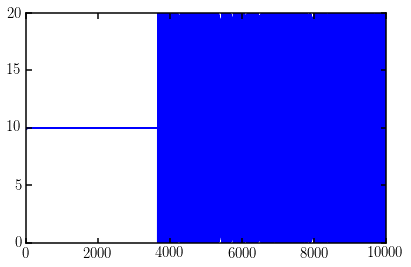

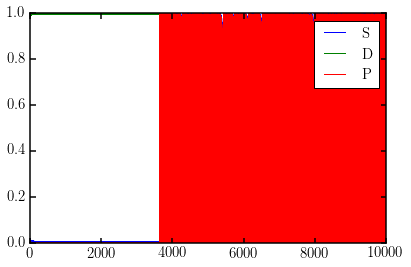

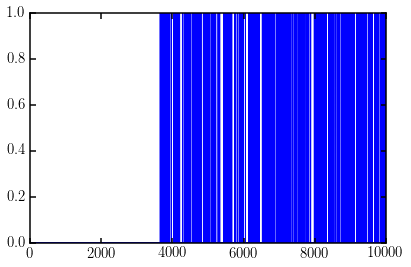

In [32]:
t_program = time.time()

dt = 0.01
Nt = 1000000
omegaP = 20
omegaD = 10
index_start = 10000
index_end = 10100
time_vector = np.linspace(0,Nt*dt,Nt)
#pulseD = Pi_pulse(time_vector, index_start, index_end, omegaD)
# pulseD = 0.3* np.sin(time_vector*omegaD)
pulseD = np.zeros((Nt))
pulseP = np.sin(time_vector*omegaP)
three_level_driving(pulseD, pulseP, omegaD, omegaP, gammaP = 0.1, Nt = Nt, dt = dt, Ns = 1)

elapsed = time.time() - t_program
print(elapsed)